<a href="https://colab.research.google.com/github/rabnawaz172/Voice_pathology_2/blob/main/Voice_deep_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Processing 111 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Train
Processing 117 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Train
Processing 47 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Test_2
Processing 49 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Test_2


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 584ms/step - accuracy: 0.5802 - loss: 9.6356 - val_accuracy: 0.3913 - val_loss: 3.8405
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5600 - loss: 2.9731 - val_accuracy: 0.6087 - val_loss: 0.6452
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5218 - loss: 0.8480 - val_accuracy: 0.6522 - val_loss: 0.6340
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6737 - loss: 0.5901 - val_accuracy: 0.7826 - val_loss: 0.5543
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7575 - loss: 0.5417 - val_accuracy: 0.7826 - val_loss: 0.4926
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7274 - loss: 0.5376 - val_accuracy: 0.8043 - val_loss: 0.4918
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7603 - loss: 0.5047 - val_accuracy: 0.8261 - val_loss: 0.5046
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8149 - loss: 0.4373 - val_accuracy: 0.7391 - val_loss

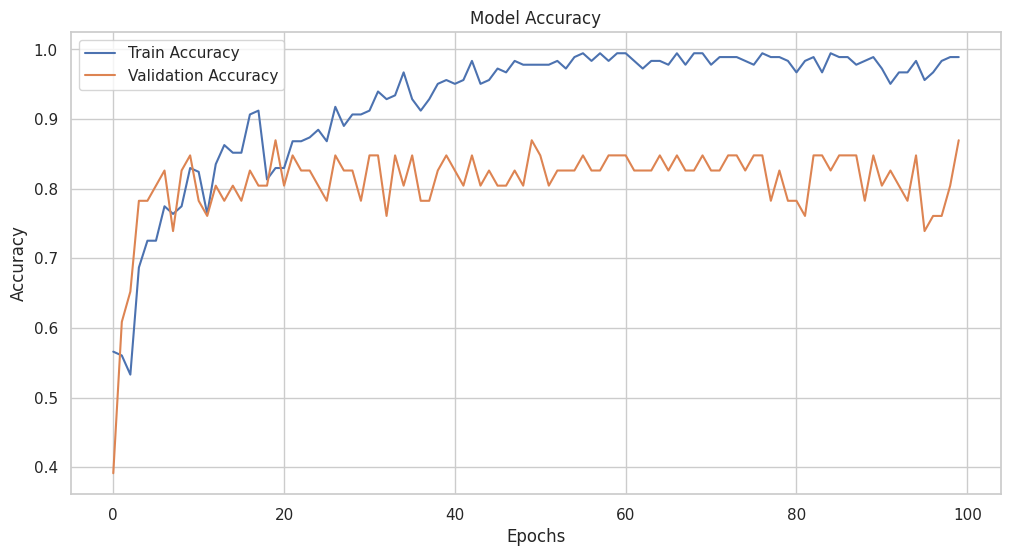

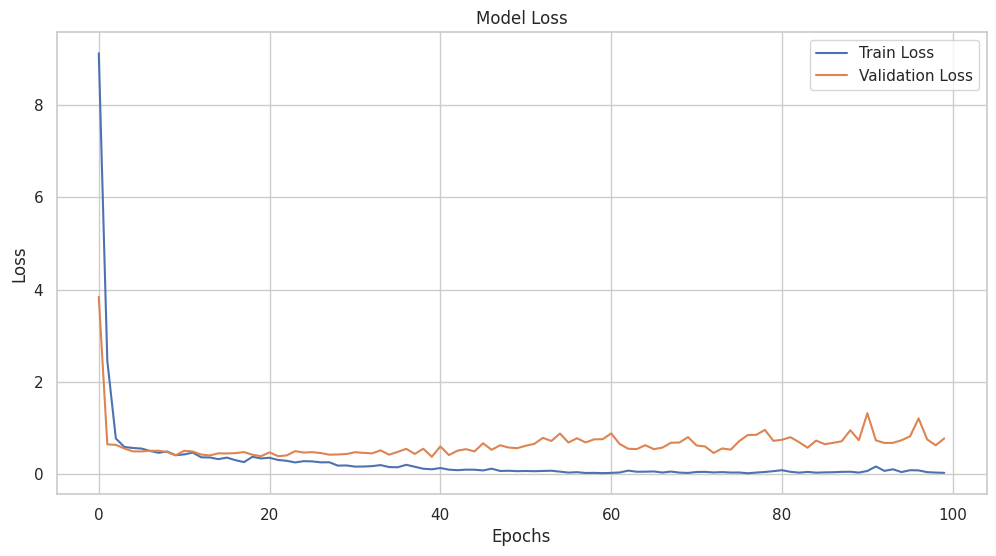

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style with grid
sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000  # 1 second at 16kHz
N_MELS = 64
TIME_STEPS = 32  # Desired time steps for model input

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH, time_steps=TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Pad or truncate audio to MAX_AUDIO_LENGTH
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure time_steps = 32 by padding or truncating
        t = mel_spec_db.shape[1]
        if t < time_steps:
            pad_width = time_steps - t
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif t > time_steps:
            mel_spec_db = mel_spec_db[:, :time_steps]

        # Expand to 3 channels (RGB-like)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

        return mel_spec_db_rgb

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, time_steps, 3))  # Return zero vector in case of error

# Function to load all data from a base path
def load_data(base_path, classes, labels):
    features = []
    targets = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}' from {base_path}")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Load training data (used for train + validation)
X_train_val, y_train_val = load_data(train_path, classes, labels)

# Load test data (unseen, used only for final evaluation)
X_test, y_test = load_data(test_path, classes, labels)

# Split training data into train and validation (80% train, 20% val)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Build the CNN model
model_hyb = models.Sequential([
    layers.InputLayer(input_shape=(N_MELS, TIME_STEPS, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_hyb.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_hyb = model_hyb.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate on validation data
Y_val_pred = (model_hyb.predict(X_val) > 0.5).astype(int)

val_accuracy = accuracy_score(Y_val, Y_val_pred)
val_precision = precision_score(Y_val, Y_val_pred)
val_recall = recall_score(Y_val, Y_val_pred)
val_f1 = f1_score(Y_val, Y_val_pred)

print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Evaluate on test data
Y_test_pred = (model_hyb.predict(X_test) > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, Y_test_pred)
test_precision = precision_score(y_test, Y_test_pred)
test_recall = recall_score(y_test, Y_test_pred)
test_f1 = f1_score(y_test, Y_test_pred)



# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['accuracy'], label='Train Accuracy')
plt.plot(history_hyb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['loss'], label='Train Loss')
plt.plot(history_hyb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 543ms/step - accuracy: 0.4768 - loss: 2.1192 - val_accuracy: 0.6875 - val_loss: 0.6390
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5542 - loss: 1.3841 - val_accuracy: 0.7188 - val_loss: 0.5470
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5793 - loss: 1.2806 - val_accuracy: 0.7604 - val_loss: 0.4820
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6541 - loss: 1.0050 - val_accuracy: 0.7917 - val_loss: 0.4355
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5950 - loss: 0.9472 - val_accuracy: 0.8125 - val_loss: 0.4201
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6352 - loss: 0.8984 - val_accuracy: 0.7708 - val_loss: 0.4299
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6081 - loss: 0.9193 - val_accuracy: 0.8021 - val_loss: 0.4198
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.65

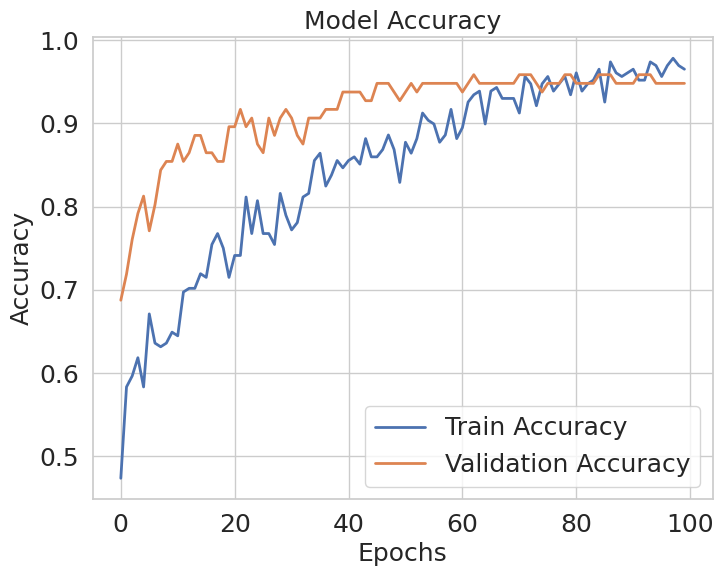

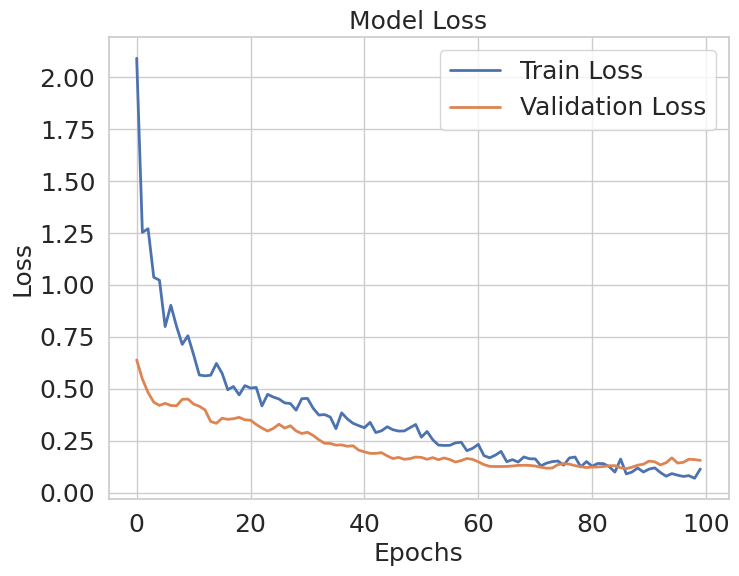

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)

# Build the VGGish model for transfer learning
# Load VGG16 as base model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_trans = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_trans.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_trans = model_trans.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    verbose=1
)

# Evaluate the model
Y_val_pred_trans = (model_trans.predict(X_val) > 0.5).astype(int)

accuracy = accuracy_score(Y_val, Y_val_pred_trans)
precision = precision_score(Y_val, Y_val_pred_trans)
recall = recall_score(Y_val, Y_val_pred_trans)
f1 = f1_score(Y_val, Y_val_pred_trans)

print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Plot training loss history
plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

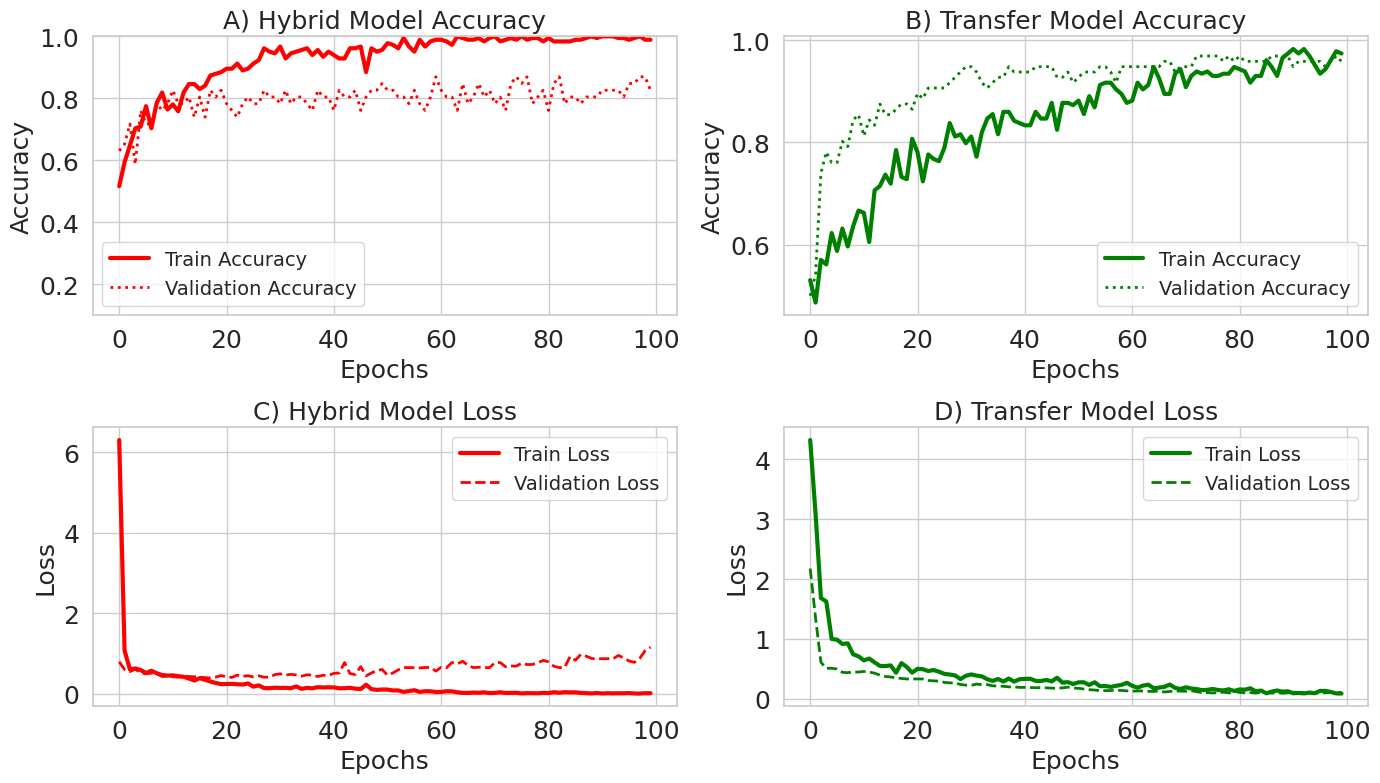

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ----------------------------
# Subplot A: Hybrid Model - Accuracy
# ----------------------------
axes[0, 0].plot(history_hyb.history['accuracy'], label='Train Accuracy', linewidth=3, color='red')
axes[0, 0].plot(history_hyb.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='red')
axes[0, 0].set_title('A) Hybrid Model Accuracy', fontsize=18)
axes[0, 0].set_xlabel('Epochs', fontsize=18)
axes[0, 0].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)  # Focus on 90% to 100% range
axes[0, 0].tick_params(axis='both', which='major', labelsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 0].grid(True)

# ----------------------------
# Subplot B: Transfer Model - Accuracy
# ----------------------------
axes[0, 1].plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=3, color='green')
axes[0, 1].plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='green')
axes[0, 1].set_title('B) Transfer Model Accuracy', fontsize=18)
axes[0, 1].set_xlabel('Epochs', fontsize=18)
axes[0, 1].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)
axes[0, 1].tick_params(axis='both', which='major', labelsize=18)
axes[0, 1].legend(fontsize=14)
axes[0, 1].grid(True)

# ----------------------------
# Subplot C: Hybrid Model - Loss
# ----------------------------
axes[1, 0].plot(history_hyb.history['loss'], label='Train Loss', linewidth=3, color='red')
axes[1, 0].plot(history_hyb.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='red')
axes[1, 0].set_title('C) Hybrid Model Loss', fontsize=18)
axes[1, 0].set_xlabel('Epochs', fontsize=18)
axes[1, 0].set_ylabel('Loss', fontsize=18)


axes[1, 0].tick_params(axis='both', which='major', labelsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 0].grid(True)

# ----------------------------
# Subplot D: Transfer Model - Loss
# ----------------------------
axes[1, 1].plot(history_trans.history['loss'], label='Train Loss', linewidth=3, color='green')
axes[1, 1].plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='green')
axes[1, 1].set_title('D) Transfer Model Loss', fontsize=18)
axes[1, 1].set_xlabel('Epochs', fontsize=18)
axes[1, 1].set_ylabel('Loss', fontsize=18)

axes[1, 1].tick_params(axis='both', which='major', labelsize=18)
axes[1, 1].legend(fontsize=14)
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

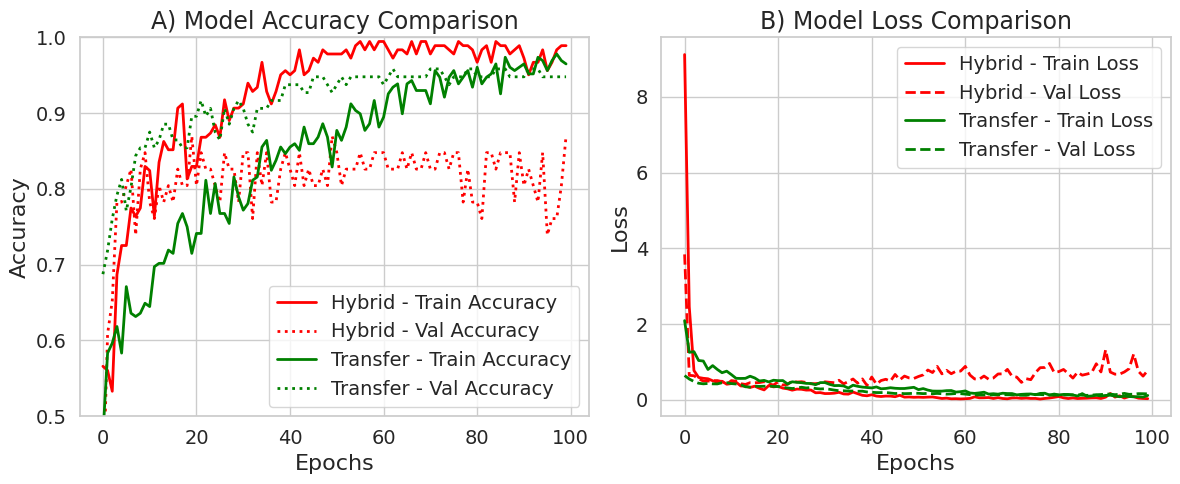

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files # Import files module
from google.colab import files
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure for side-by-side layout

# ----------------------------
# Subplot 0: Accuracy Comparison (Left)
# ----------------------------
# Hybrid model accuracy
axes[0].plot(history_hyb.history['accuracy'], label='Hybrid - Train Accuracy', linewidth=2, color='red')
axes[0].plot(history_hyb.history['val_accuracy'], label='Hybrid - Val Accuracy', linewidth=2, linestyle='dotted', color='red')

# Transfer learning model accuracy
axes[0].plot(history_trans.history['accuracy'], label='Transfer - Train Accuracy', linewidth=2, color='green')
axes[0].plot(history_trans.history['val_accuracy'], label='Transfer - Val Accuracy', linewidth=2, linestyle='dotted', color='green')

axes[0].set_title('A) Model Accuracy Comparison', fontsize=17)  # Added "A)"
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=16)
axes[0].set_ylim(0.5, 1.0)  # Focus on relevant range
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=14)
axes[0].grid(True)

# ----------------------------
# Subplot 1: Loss Comparison (Right)
# ----------------------------
# Hybrid model loss
axes[1].plot(history_hyb.history['loss'], label='Hybrid - Train Loss', linewidth=2, color='red')
axes[1].plot(history_hyb.history['val_loss'], label='Hybrid - Val Loss', linewidth=2, linestyle='dashed', color='red')

# Transfer learning model loss
axes[1].plot(history_trans.history['loss'], label='Transfer - Train Loss', linewidth=2, color='green')
axes[1].plot(history_trans.history['val_loss'], label='Transfer - Val Loss', linewidth=2, linestyle='dashed', color='green')

axes[1].set_title('B) Model Loss Comparison', fontsize=17)  # Added "B)"
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=14)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# Save the figure to disk at 600 DPI
plt.savefig('train_valid_1.png', dpi=600, bbox_inches='tight')
# Show the combined figure
plt.show()


# Download the saved image
files.download('train_valid_1.png')

In [ ]:
model_hyb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,429 (6.22 MB)

 Trainable params: 543,809 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,087,620 (4.15 MB)

In [ ]:
model_trans.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,936,645 (56.98 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 147,972 (578.02 KB)

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'


In [ ]:
def load_data(base_path, classes, labels):
    features = []
    targets = []
    file_paths = []  # To store the file paths

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
            file_paths.append(file)  # Store the file path

    return np.array(features), np.array(targets), np.array(file_paths)
    print("Loading test dataset...")
X_test, Y_test, file_paths = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")
# Predict on the test set
Y_pred_prob = model_trans.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

# Identify incorrectly predicted Pathol samples
incorrect_pathol_files = []

for i in range(len(Y_test)):
    if Y_test[i] == 1 and Y_pred[i] == 0:  # True label is Pathol, predicted as Normal
        incorrect_pathol_files.append(file_paths[i])

# Print the list of incorrectly predicted Pathol files
print("\nIncorrectly predicted Pathol files:")
for file in incorrect_pathol_files:
    print(file)

Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
Test data shape: (96, 64, 32, 3), Labels shape: (96,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Incorrectly predicted Pathol files:
/content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-62007-nor-f-22-n-430201315-kaf-0-p.wav
/content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav


In [ ]:
# Predict on validation set for both models (if not already done)
print("Predicting on validation set...")

Y_val_pred_prob_1 = model_hyb.predict(X_val)  # Hybrid model
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()

Y_val_pred_prob_2 = model_trans.predict(X_val)  # Transfer Learning model
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()

Predicting on validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


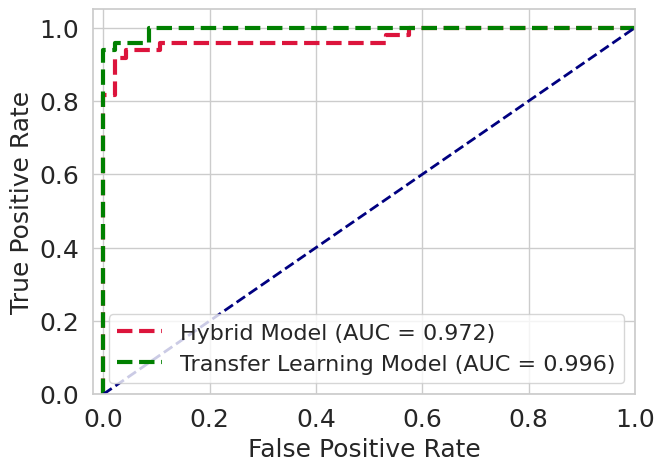

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for model_1 (assuming sigmoid output)
fpr_1, tpr_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)  # Use predicted probabilities from model_1
roc_auc_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

# Calculate ROC curve and AUC for model_2 (assuming sigmoid output)
fpr_2, tpr_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)  # Use predicted probabilities from model_2
roc_auc_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

# Create a single figure
plt.figure(figsize=(7,5))

# Plot ROC curve for model_1
plt.plot(fpr_1, tpr_1, label=f'Hybrid Model (AUC = {roc_auc_1:.3f})', linestyle='--', linewidth=3, color='crimson')

# Plot ROC curve for model_2
plt.plot(fpr_2, tpr_2, label=f'Transfer Learning Model (AUC = {roc_auc_2:.3f})', linestyle='--', linewidth=3, color='green')

# Plot the diagonal line (random classifier reference)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)

# Add title, labels, and legend

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlim([-0.02, 1.0])  # Adjust x-axis limits to start from -0.02
plt.ylim([0.0, 1.05])   # Adjust y-axis limits
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid(True)

# Show the combined figure
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


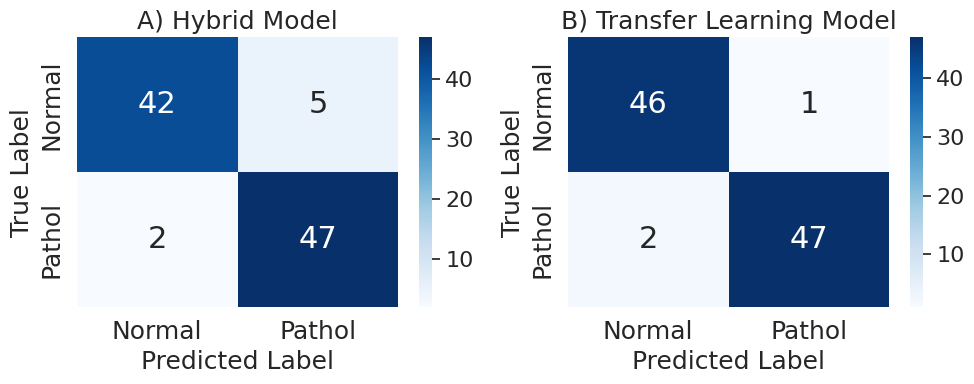

Model 1 Metrics:
Accuracy: 0.93
Precision: 0.90
Recall: 0.96
F1 Score: 0.93

Model 2 Metrics:
Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97

Files misclassified by both models:
File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
  True Label: Normal | Model 1 Prediction: Pathol | Model 2 Prediction: Pathol
File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-62007-nor-f-22-n-430201315-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal
File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    file_paths = []  # To store corresponding file paths
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
            file_paths.append(file)  # Save the file path
    return np.array(features), np.array(target), file_paths

# Load training and validation data
X_train, Y_train, train_files = load_data(train_path, classes, labels)
X_val, Y_val, val_files = load_data(test_path, classes, labels)

# Predict on the validation set for model_1
Y_val_pred_prob_1 = model_hyb.predict(X_val)
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_1
cm_1 = confusion_matrix(Y_val, Y_val_pred_1, labels=[0, 1])

# Predict on the validation set for model_2
Y_val_pred_prob_2 = model_trans.predict(X_val)
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_2
cm_2 = confusion_matrix(Y_val, Y_val_pred_2, labels=[0, 1])

# Plot confusion matrices (same as before)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns_heatmap_1 = sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[0])
axes[0].set_title('A) Hybrid Model', fontsize=18)
axes[0].set_xlabel('Predicted Label', fontsize=18)
axes[0].set_ylabel('True Label', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
for text in axes[0].texts:
    text.set_fontsize(22)
cbar_1 = sns_heatmap_1.collections[0].colorbar
cbar_1.ax.tick_params(labelsize=16)

sns_heatmap_2 = sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[1])
axes[1].set_title('B) Transfer Learning Model', fontsize=18)
axes[1].set_xlabel('Predicted Label', fontsize=18)
axes[1].set_ylabel('True Label', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
for text in axes[1].texts:
    text.set_fontsize(22)
cbar_2 = sns_heatmap_2.collections[0].colorbar
cbar_2.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

# Print evaluation metrics for model_1
accuracy_1 = accuracy_score(Y_val, Y_val_pred_1)
precision_1 = precision_score(Y_val, Y_val_pred_1)
recall_1 = recall_score(Y_val, Y_val_pred_1)
f1_1 = f1_score(Y_val, Y_val_pred_1)

print("Model 1 Metrics:")
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Print evaluation metrics for model_2
accuracy_2 = accuracy_score(Y_val, Y_val_pred_2)
precision_2 = precision_score(Y_val, Y_val_pred_2)
recall_2 = recall_score(Y_val, Y_val_pred_2)
f1_2 = f1_score(Y_val, Y_val_pred_2)

print("\nModel 2 Metrics:")
print(f"Accuracy: {accuracy_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")

# Find files misclassified by both models
Y_val_true = np.array(Y_val).flatten()
Y_val_pred_1_flat = Y_val_pred_1
Y_val_pred_2_flat = Y_val_pred_2

misclassified_by_both = [
    i for i in range(len(Y_val_true))
    if Y_val_true[i] != Y_val_pred_1_flat[i] and Y_val_true[i] != Y_val_pred_2_flat[i]
]

# Print file names misclassified by both models
print("\nFiles misclassified by both models:")
for idx in misclassified_by_both:
    true_label = classes[Y_val_true[idx]]
    pred_label_1 = classes[Y_val_pred_1_flat[idx]]
    pred_label_2 = classes[Y_val_pred_2_flat[idx]]
    file_path = val_files[idx]
    print(f"File: {file_path}")
    print(f"  True Label: {true_label} | "
          f"Model 1 Prediction: {pred_label_1} | "
          f"Model 2 Prediction: {pred_label_2}")

In [ ]:
from sklearn.metrics import classification_report

# Define model names for display
model_names = ['model_hybrid', 'model_trans']

# List of true labels and predictions
y_true = Y_val
preds_list = [Y_val_pred_1, Y_val_pred_2]

print("\n📋 Per-Class Evaluation Metrics (Precision, Recall, F1-Score)")

for idx, preds in enumerate(preds_list):
    print(f"\n✅ {model_names[idx]}:")
    report = classification_report(
        y_true,
        preds,
        target_names=classes,
        digits=4
    )
    print(report)


📋 Per-Class Evaluation Metrics (Precision, Recall, F1-Score)

✅ model_hybrid:
              precision    recall  f1-score   support

      Normal     0.9545    0.8936    0.9231        47
      Pathol     0.9038    0.9592    0.9307        49

    accuracy                         0.9271        96
   macro avg     0.9292    0.9264    0.9269        96
weighted avg     0.9287    0.9271    0.9270        96


✅ model_trans:
              precision    recall  f1-score   support

      Normal     0.9583    0.9787    0.9684        47
      Pathol     0.9792    0.9592    0.9691        49

    accuracy                         0.9688        96
   macro avg     0.9688    0.9690    0.9687        96
weighted avg     0.9690    0.9688    0.9688        96



In [ ]:
# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_1_flat: predictions from Model 1
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol)
false_positives = [
    i for i in normal_indices
    if Y_val_pred_1_flat[i] == 1
]

# Find false negatives (Pathol -> Normal)
false_negatives = [
    i for i in pathol_indices
    if Y_val_pred_1_flat[i] == 0
]

# Print results
print("\n🔴 False Positives (Normal misclassified as Pathol):")
for idx in false_positives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\n🔵 False Negatives (Pathol misclassified as Normal):")
for idx in false_negatives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


🔴 False Positives (Normal misclassified as Pathol):
File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1-12007-cyt-m-22-n -554203-kam-x-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1my-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1my-62007-nor-m-x-x-90053-kam-x-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1my-1300D7FyWy-cyt-m-10-n-496364-kaf-3-p.wav
  True Label: Normal | Prediction: Pathol


🔵 False Negatives (Pathol misclassified as Normal):
File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-62007-nor-f-22-n-430201315-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-621-nor-f-20-n-430

In [ ]:
# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_2_flat: predictions from Model 2
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol) for Model 2
false_positives_model2 = [
    i for i in normal_indices
    if Y_val_pred_2_flat[i] == 1
]

# Find false negatives (Pathol -> Normal) for Model 2
false_negatives_model2 = [
    i for i in pathol_indices
    if Y_val_pred_2_flat[i] == 0
]

# Print results for Model 2
print("\n🔴 False Positives (Normal misclassified as Pathol) - Model 2:")
for idx in false_positives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\n🔵 False Negatives (Pathol misclassified as Normal) - Model 2:")
for idx in false_negatives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


🔴 False Positives (Normal misclassified as Pathol) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_2/Normal/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
  True Label: Normal | Prediction: Pathol


🔵 False Negatives (Pathol misclassified as Normal) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-62007-nor-f-22-n-430201315-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_2/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal



Processing 111 files in 'Normal'
Processing 117 files in 'Pathol'
Processing 47 files in 'Normal'
Processing 49 files in 'Pathol'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)



Training SVM...
SVM - Val Acc: 0.8043, Test F1: 0.8713

📊 Performance Comparison:
+----+---------+----------------+-----------------+----------+-----------+
|    | Model   |   Val Accuracy |   Test Accuracy |   Val F1 |   Test F1 |
+====+=========+================+=================+==========+===========+
|  0 | SVM     |         0.8043 |          0.8646 |   0.8475 |    0.8713 |
+----+---------+----------------+-----------------+----------+-----------+


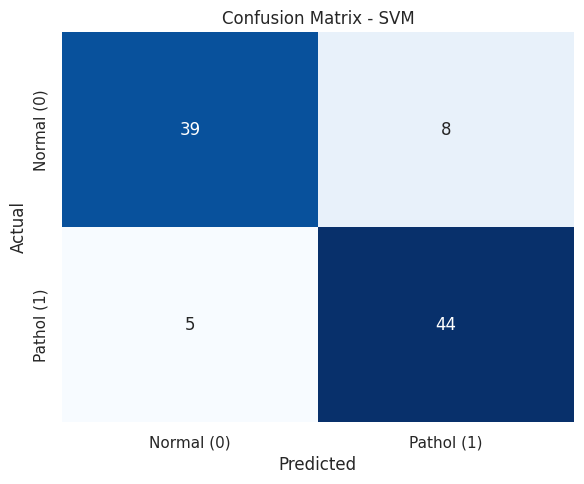

In [ ]:
import os
import numpy as np
import librosa
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'
test_path = '/content/drive/MyDrive/Voice_2/Test_4'

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000
N_MELS = 64
TIME_STEPS = 32

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < MAX_AUDIO_LENGTH:
            y = np.pad(y, (0, MAX_AUDIO_LENGTH - len(y)), mode='constant')
        else:
            y = y[:MAX_AUDIO_LENGTH]

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        t = mel_spec_db.shape[1]
        if t < TIME_STEPS:
            pad_width = TIME_STEPS - t
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif t > TIME_STEPS:
            mel_spec_db = mel_spec_db[:, :TIME_STEPS]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, TIME_STEPS))

# Load data
def load_data(base_path):
    features, targets = [], []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in '{class_name}'")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Flatten spectrograms
def flatten_data(X):
    return X.reshape(len(X), -1)

# Load datasets
X_train_val, y_train_val = load_data(train_path)
X_test, y_test = load_data(test_path)

# Split into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Flatten for ML models
X_train_flat = flatten_data(X_train)
X_val_flat = flatten_data(X_val)
X_test_flat = flatten_data(X_test)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Define models
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, Y_train)

    # Predict
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    val_acc = accuracy_score(Y_val, y_val_pred)
    val_pre = precision_score(Y_val, y_val_pred)
    val_rec = recall_score(Y_val, y_val_pred)
    val_f1 = f1_score(Y_val, y_val_pred)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_pre = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Val Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Val F1": val_f1,
        "Test F1": test_f1
    })

    print(f"{name} - Val Acc: {val_acc:.4f}, Test F1: {test_f1:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print Tabulated Results
print("\n📊 Performance Comparison:")
print(tabulate(df_results, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Confusion Matrix Plot
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal (0)', 'Pathol (1)'],
                yticklabels=['Normal (0)', 'Pathol (1)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [ ]:
print(model.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, Y_train)

    # Predict
    y_train_pred = model.predict(X_train_scaled)  # <-- NEW: Predict on training set
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    train_acc = accuracy_score(Y_train, y_train_pred)  # <-- NEW: Training accuracy
    val_acc = accuracy_score(Y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    val_pre = precision_score(Y_val, y_val_pred)
    val_rec = recall_score(Y_val, y_val_pred)
    val_f1 = f1_score(Y_val, y_val_pred)

    test_pre = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,   # <-- Added
        "Val Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Val F1": val_f1,
        "Test F1": test_f1
    })

    print(f"{name} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test F1: {test_f1:.4f}")


Training SVM...
SVM - Train Acc: 0.9670, Val Acc: 0.8043, Test F1: 0.8713


In [ ]:
from sklearn.metrics import classification_report

for name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)

    # Generate classification report
    print(f"\n📋 Classification Report - {name}")
    print(classification_report(y_test, y_test_pred, target_names=classes, digits=4))


📋 Classification Report - SVM
              precision    recall  f1-score   support

      Normal     0.8864    0.8298    0.8571        47
      Pathol     0.8462    0.8980    0.8713        49

    accuracy                         0.8646        96
   macro avg     0.8663    0.8639    0.8642        96
weighted avg     0.8658    0.8646    0.8644        96



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in /content/drive/MyDrive/Voice_2/Train/Normal/*.wav: 111
Files in /content/drive/MyDrive/Voice_2/Train/Pathol/*.wav: 117


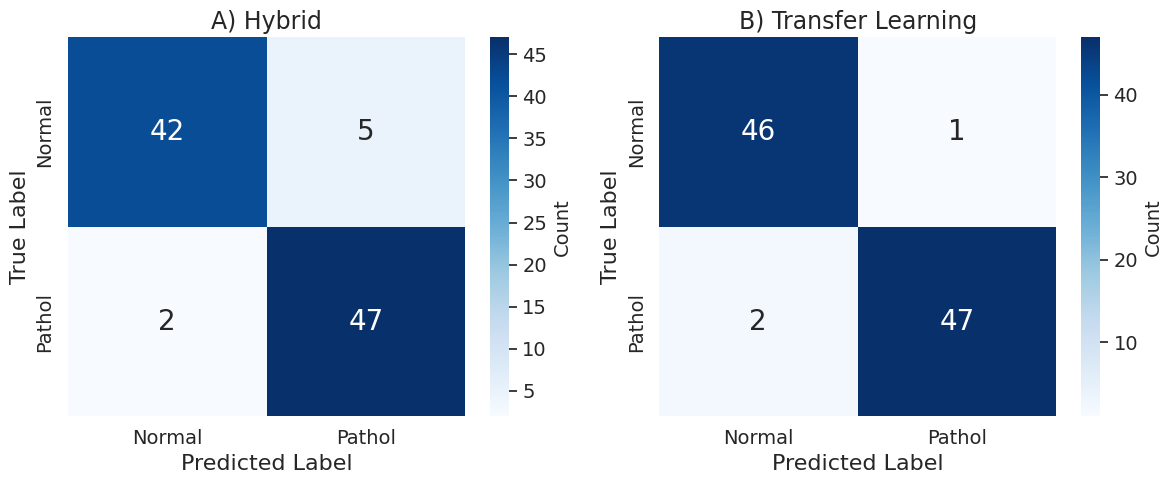

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Learning Models ---
# Assuming:
# cm_1 = confusion_matrix(Y_val, Y_val_pred_1)  --> Hybrid
# cm_2 = confusion_matrix(Y_val, Y_val_pred_2)  --> Transfer Learning

# Combine only deep learning confusion matrices
cms = [cm_1, cm_2]

titles = [
    'A) Hybrid',
    'B) Transfer Learning',
]

# Create a figure with 1x2 layout (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pathol'],
                yticklabels=['Normal', 'Pathol'], cbar=True, ax=ax)

    ax.set_title(titles[i], fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Increase annotation font size
    for text in ax.texts:
        text.set_fontsize(20)

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Count', fontsize=14)

plt.tight_layout()
plt.savefig('cm_13.png', dpi=700, bbox_inches='tight', facecolor='white')
plt.show()


# Download the saved image
files.download('cm_13.png')

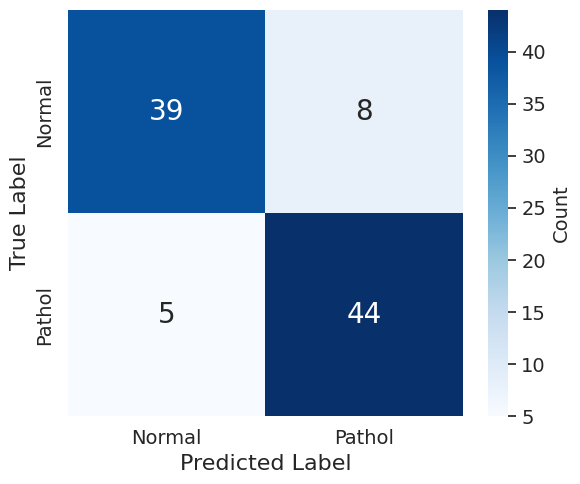

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from SVM model
y_pred_svm = model.predict(X_test_scaled)  # Make sure this is already defined
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Normal', 'Pathol'],
                 yticklabels=['Normal', 'Pathol'])


plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)

# Set font size for x and y tick labels
ax.tick_params(axis='both', which='major', labelsize=14)

# Increase annotation font size inside heatmap
for text in ax.texts:
    text.set_fontsize(20)

# Access colorbar and set font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Colorbar ticks
cbar.set_label('Count', fontsize=14)  # Colorbar label

plt.tight_layout()
plt.savefig('svm_cm_13.png', dpi=700, bbox_inches='tight', facecolor='white')
plt.show()
files.download('svm_cm_13.png')

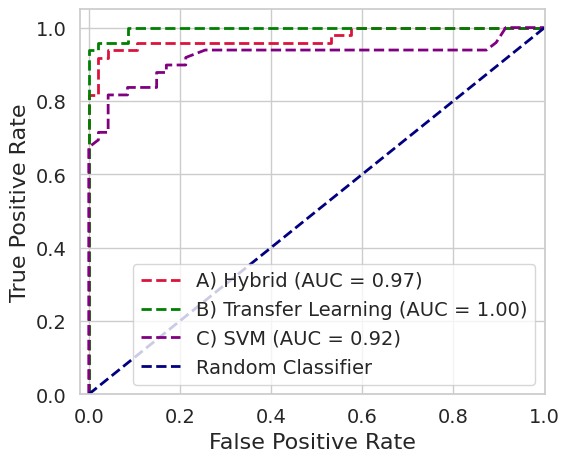

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Deep Learning Models ---
# Assume fpr_1, tpr_1, roc_auc_1 are already computed from model_1
# Same for fpr_2, tpr_2, roc_auc_2 from model_2

# --- Machine Learning Models ---
roc_data = []
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data.append({
        'name': name,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    })

# --- Plotting Section ---

plt.figure(figsize=(6, 5))

# A) Hybrid Model (DL)
plt.plot(fpr_1, tpr_1,
         label=f'A) Hybrid (AUC = {roc_auc_1:.2f})',
         linestyle='--', linewidth=2, color='crimson')

# B) Transfer Learning Model (DL)
plt.plot(fpr_2, tpr_2,
         label=f'B) Transfer Learning (AUC = {roc_auc_2:.2f})',
         linestyle='--', linewidth=2, color='green')

# C) SVM (ML)
plt.plot(roc_data[0]['fpr'], roc_data[0]['tpr'],
         label=f'C) SVM (AUC = {roc_data[0]["auc"]:.2f})',
         linestyle='--', linewidth=2, color='purple')



# Random classifier line
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--', linewidth=2, label='Random Classifier')

# Formatting
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig('roc.png', dpi=700, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
files.download('roc.png')

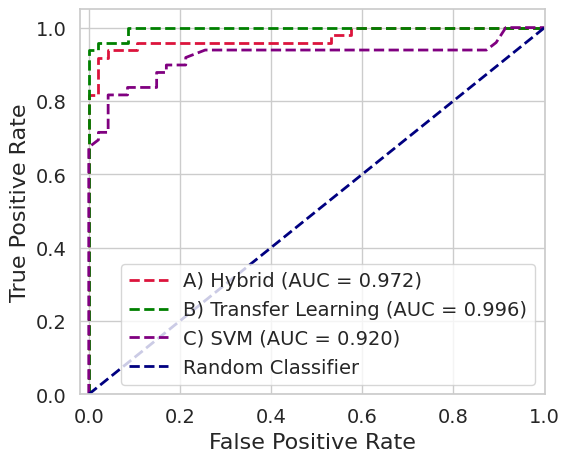

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Deep Learning Models ---
# Assume fpr_1, tpr_1, roc_auc_1 are already computed from model_1
# Same for fpr_2, tpr_2, roc_auc_2 from model_2

# --- Machine Learning Models ---
roc_data = []
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data.append({
        'name': name,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    })

# --- Plotting Section ---

plt.figure(figsize=(6, 5))

# A) Hybrid Model (DL)
plt.plot(fpr_1, tpr_1,
         label=f'A) Hybrid (AUC = {roc_auc_1:.3f})',
         linestyle='--', linewidth=2, color='crimson')

# B) Transfer Learning Model (DL)
plt.plot(fpr_2, tpr_2,
         label=f'B) Transfer Learning (AUC = {roc_auc_2:.3f})',
         linestyle='--', linewidth=2, color='green')

# C) SVM (ML)
plt.plot(roc_data[0]['fpr'], roc_data[0]['tpr'],
         label=f'C) SVM (AUC = {roc_data[0]["auc"]:.3f})',
         linestyle='--', linewidth=2, color='purple')



# Random classifier line
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--', linewidth=2, label='Random Classifier')

# Formatting
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig('roc_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
files.download('roc_1.png')

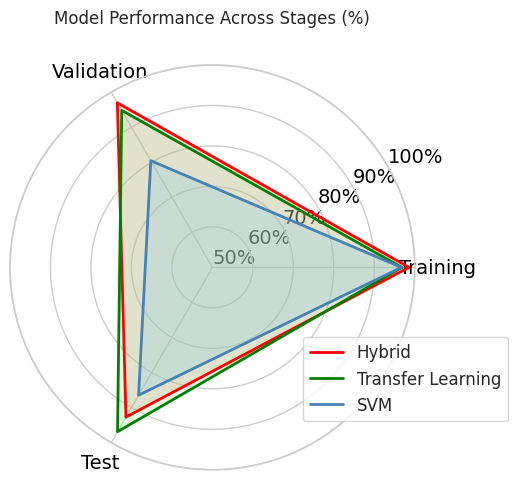

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Model names
model_names = ['Hybrid', 'Transfer Learning', 'SVM']

# Metrics data (in percentages)
data = {
    'Training': [98.58, 96.82,96.70 ],
    'Validation': [96.96,94.79,80.43],
    'Test': [92.71, 96.88, 86.46]
}

# Custom colors for each model
model_colors = {
    'Hybrid': ('red', 'lightcoral'),
    'Transfer Learning': ('green', 'lightgreen'),
    'SVM': ('steelblue', 'skyblue'),
    'RF': ('purple', 'violet')
}

# Categories and angles
categories = list(data.keys())
N = len(categories)

# Generate evenly spaced angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Set up plot
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(polar=True))

# Plot each model
for i, model_name in enumerate(model_names):
    values = [data[c][i] for c in categories]
    values += values[:1]  # Close the loop

    line_color, fill_color = model_colors[model_name]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=line_color)
    ax.fill(angles, values, color=fill_color, alpha=0.25)

# Fix axis labels and formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=14, color='black')
ax.set_rlabel_position(30)

# 🔁 Custom Y-Ticks: Start from 50%
ytick_values = [50, 60, 70, 80, 90, 100]
ytick_labels = ["50%", "60%", "70%", "80%", "90%", "100%"]

plt.yticks(ytick_values, ytick_labels, color="black", size=14)
plt.ylim(50, 100)  # Set y-axis limits from 50 to 100

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.1), fontsize=12)

# Show plot
plt.title('Model Performance Across Stages (%)', pad=30)
plt.tight_layout()
plt.show()

<ipython-input-4-182502685>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=model_names, y=test_accuracy, palette="viridis")


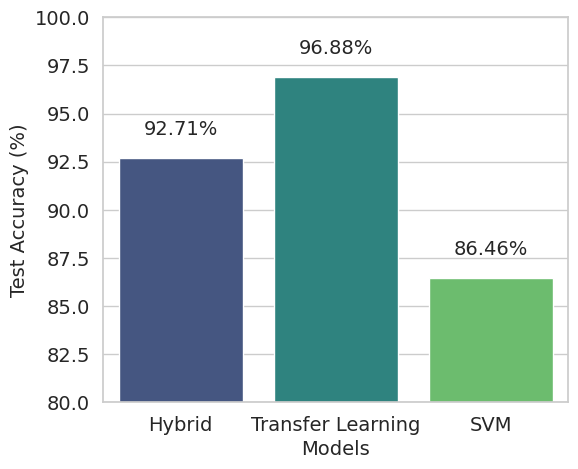

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files # Import the files object

# Model names
model_names = ['Hybrid', 'Transfer Learning', 'SVM']

# Test accuracy values
test_accuracy = [92.71, 96.88, 86.46]

# Set style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(6, 5))
barplot = sns.barplot(x=model_names, y=test_accuracy, palette="viridis")

# Add percentage labels on top of bars
for index, value in enumerate(test_accuracy):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=14)

# Titles and labels

plt.xlabel('Models', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(80, 100)  # Limit y-axis for better comparison
plt.tick_params(axis='both', which='major', labelsize=14)
# Show plot
plt.savefig('acc_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
files.download('acc_1.png')

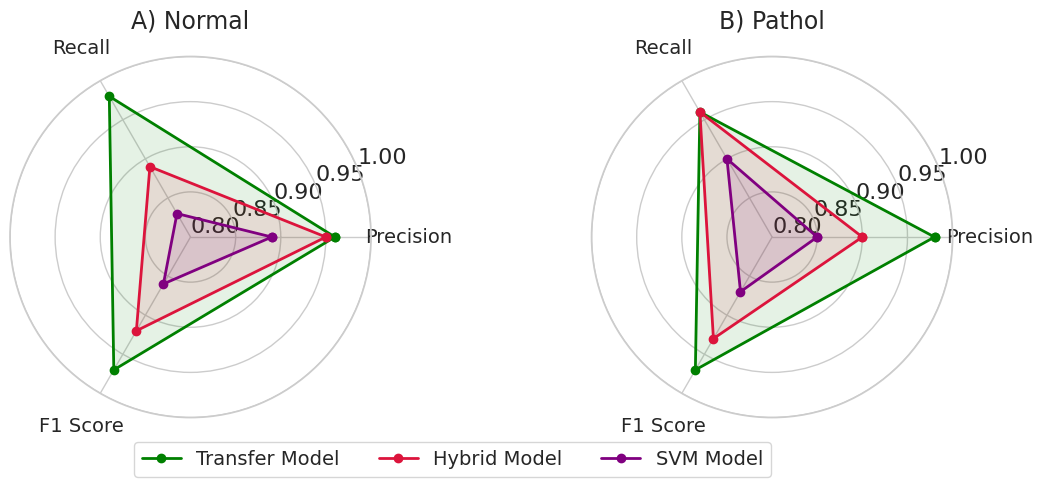

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for each model
metrics = ['Precision', 'Recall', 'F1 Score']
transfer_model_norm = [0.96  ,  0.98  ,  0.97]  # Precision, Recall, F1 Score
hybrid_model_norm = [0.95  ,  0.89  ,  0.92]
svm_model_norm = [0.89 ,   0.83  ,  0.86 ]  # Example values for SVM


transfer_model_pathol = [0.98,    0.96,    0.97]
hybrid_model_pathol = [0.90,    0.96,    0.93]
svm_model_pathol = [ 0.85 ,   0.90 ,   0.87 ]  # Example values for SVM

# Function to create a radar plot with three models
# Model names and colors
model_names = ['Transfer Model', 'Hybrid Model', 'SVM Model']
model_colors = {
    'Transfer Model': 'green',
    'Hybrid Model': 'crimson',
    'SVM Model': 'purple'
}

# Function to create a radar plot with three models
def create_radar_plot(ax, data_1, data_2, data_3, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Extend data to complete the loop
    data_1 += data_1[:1]
    data_2 += data_2[:1]
    data_3 += data_3[:1]

    # Plot data
    ax.plot(angles, data_1, label='Transfer Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['Transfer Model'])
    ax.fill(angles, data_1, color=model_colors['Transfer Model'], alpha=0.1)

    ax.plot(angles, data_2, label='Hybrid Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['Hybrid Model'])
    ax.fill(angles, data_2, color=model_colors['Hybrid Model'], alpha=0.1)

    ax.plot(angles, data_3, label='SVM Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['SVM Model'])
    ax.fill(angles, data_3, color=model_colors['SVM Model'], alpha=0.1)

    # Axis setup
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14,pad=3)

    # Set fewer radial ticks
    ax.set_yticks([0.80, 0.85, 0.90, 0.95, 1.00])
    ax.set_yticklabels(['0.80', '0.85', '0.90', '0.95', '1.00'], fontsize=16)
    ax.set_ylim(0.80, 1.00)

    # Title
    ax.set_title(title, fontsize=17, pad=20)
    ax.tick_params(pad=14)  # Increase label padding

    return ax

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(polar=True))

# Plot Normal class
create_radar_plot(
    axes[0],
    transfer_model_norm,
    hybrid_model_norm,
    svm_model_norm,
    metrics,
    title="A) Normal"
)

# Plot Pathol class
create_radar_plot(
    axes[1],
    transfer_model_pathol,
    hybrid_model_pathol,
    svm_model_pathol,
    metrics,
    title="B) Pathol"
)

# Create a single legend for all models
handles = [
    plt.Line2D([0], [0], color=model_colors[name], lw=2, linestyle='solid', marker='o')
    for name in model_names
]

fig.legend(handles, model_names, loc='lower center', bbox_to_anchor=(0.45, -0.04), ncol=3, fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space at bottom for legend
plt.savefig('radar_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
files.download('radar_1.png')